In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn import cluster, decomposition, manifold, metrics, preprocessing

Function to read the images and convert them to 5D vectors for each pixel:

In [2]:
def readImg(imgPath):
    img = Image.open(imgPath)
    pixels = img.convert('RGB')
    colours = np.array(pixels.getdata()).reshape(img.size + (3,))
    indicesArray = np.moveaxis(np.indices(img.size), 0, 2)
    allArray = np.dstack((indicesArray, colours)).reshape((-1, 5))

    df = pd.DataFrame(allArray, columns = ['y', 'x', 'r', 'g', 'b'])
    df = df[['x', 'y', 'r', 'g', 'b']]  # reorder columns
    return df

In [3]:
images = [os.getcwd() + '/Images/42049_colorBird.jpg', os.getcwd() + '/Images/3096_colorPlane.jpg']  # images are in a dir called Images
bird = readImg(images[0])
plane = readImg(images[1])
print(bird.shape, plane.shape)

(154401, 5) (154401, 5)


Function to normalise the dataframes:

In [4]:
def normalise(df):
    vals = df.values
    scaler = preprocessing.MinMaxScaler()
    scaled = scaler.fit_transform(vals)
    df = pd.DataFrame(scaled, columns = bird.columns)
    return df

In [5]:
bird = normalise(bird)
plane = normalise(plane)

Create a random sample **without** replacement:

In [6]:
def randomSample(df, frac):
    return df.sample(frac = frac, replace = False, random_state = 1)

In [44]:
f = 5000 / bird.shape[0]  # fraction of samples
birdSample = randomSample(bird, f)
planeSample = randomSample(plane, f)
print(birdSample.shape, planeSample.shape)

(5000, 5) (5000, 5)


In [23]:
print('Fraction of samples taken:', f * 100 ,'%')

Fraction of samples taken: 3.238320995330341 %


PCA:

In [9]:
def pcaCalc(df):
    pca = decomposition.PCA(n_components = 5)
    pc = pca.fit_transform(df.values)
    return pc, pca.explained_variance_ratio_

PC1, PC2, and PC3 together account for 99.24675619193066 % of the variance, hence we select a 3D subspace


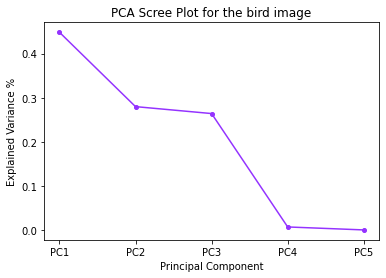

In [10]:
pc, varRatio = pcaCalc(birdSample)
print('PC1, PC2, and PC3 together account for', (varRatio[0] + varRatio[1] + varRatio[2]) * 100, '% of the variance, hence we select a 3D subspace')
plt.plot(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], varRatio, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('PCA Scree Plot for the bird image')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance %')
plt.show()
plt.close()

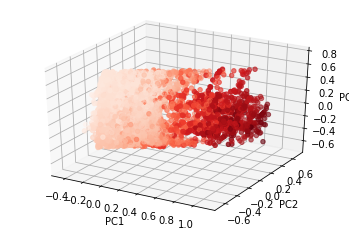

In [11]:
pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
ax = plt.axes(projection = '3d')
ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c = pc_df['PC1'], cmap = 'Reds')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()
plt.close()

PC1, PC2, and PC3 together account for 99.42030738438365 % of the variance, hence we select a 3D subspace


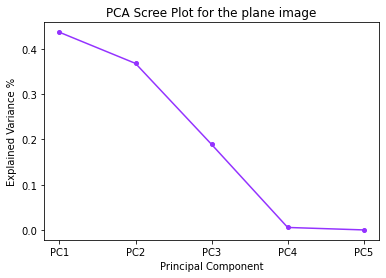

In [12]:
pc, varRatio = pcaCalc(planeSample)
print('PC1, PC2, and PC3 together account for', (varRatio[0] + varRatio[1] + varRatio[2]) * 100, '% of the variance, hence we select a 3D subspace')
plt.plot(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], varRatio, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('PCA Scree Plot for the plane image')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance %')
plt.show()
plt.close()

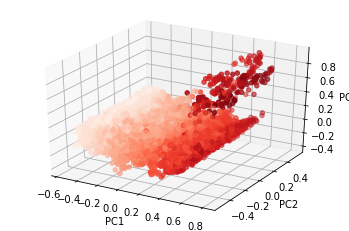

In [13]:
pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
ax = plt.axes(projection = '3d')
ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c = pc_df['PC1'], cmap = 'Reds')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()
plt.close()

t-SNE:

In [99]:
def tsneCalc(df, pplxty):
    dfEmbedded = manifold.TSNE(n_components = 2, perplexity = pplxty).fit_transform(df.values)
    return dfEmbedded

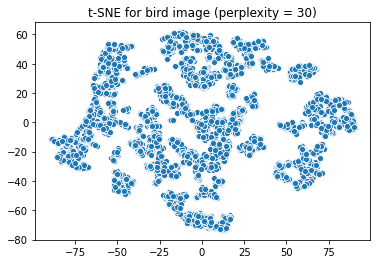

In [100]:
perpl = 30
birdTsne = tsneCalc(birdSample, perpl)
sns.scatterplot(birdTsne[:, 0], birdTsne[:, 1])
plt.title('t-SNE for bird image (perplexity = {})'.format(str(perpl)))
plt.show()
plt.close()

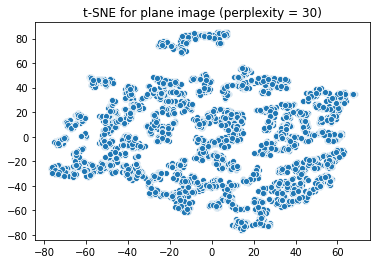

In [102]:
planeTsne = tsneCalc(planeSample, perpl)
sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1])
plt.title('t-SNE for plane image (perplexity = {})'.format(str(perpl)))
plt.show()
plt.close()

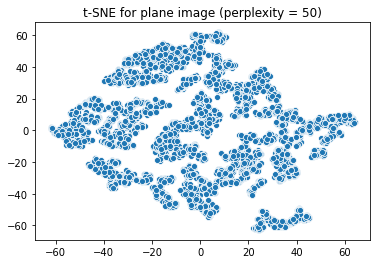

In [103]:
perpl = 50
planeTsne = tsneCalc(planeSample, perpl)
sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1])
plt.title('t-SNE for plane image (perplexity = {})'.format(str(perpl)))
plt.show()
plt.close()

Effect of pplxty: https://distill.pub/2016/misread-tsne/

k-means:

In [14]:
def kmeans(df, k):
    km = cluster.KMeans(n_clusters = k, random_state = 0).fit(df.values)
    return km

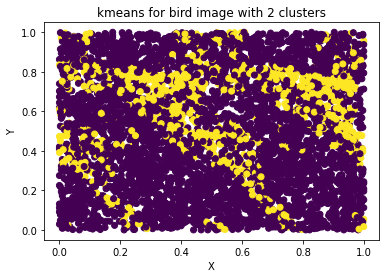

Silhouette score: 0.6147153168862521
CH score: 7348.1012069153185


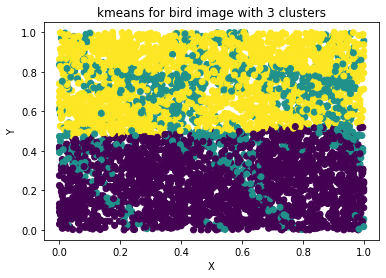

Silhouette score: 0.6797182030796581
CH score: 18631.180849221095


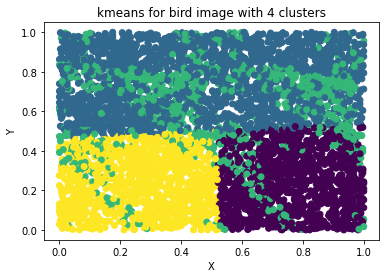

Silhouette score: 0.6925664701299843
CH score: 21313.333200749512


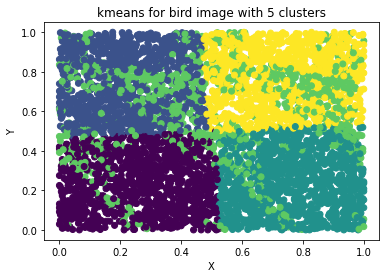

Silhouette score: 0.728866458389333
CH score: 35120.55087846468


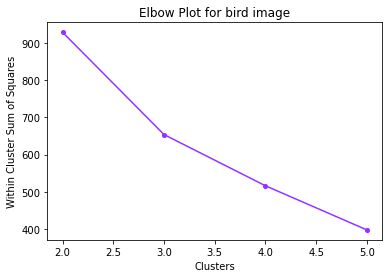

In [40]:
bird_km = []
wcss = []
silhouetteScore = []
chIndex = []

for i in range(2, 6):
    res = kmeans(birdSample, i)
    bird_km.append(res)
    birdSample['label'] = res.labels_
    plt.scatter(birdSample['x'], birdSample['y'], c = birdSample['label'])
    plt.title('kmeans for bird image with {} clusters'.format(i))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    plt.close()
    sh = metrics.silhouette_score(birdSample.values, res.labels_)
    silhouetteScore.append(sh)
    print('Silhouette score:', sh)
    ch = metrics.calinski_harabasz_score(birdSample.values, res.labels_)
    chIndex.append(ch)
    print('CH score:', ch)
    
for i in bird_km:
    wcss.append(i.inertia_)

plt.plot([2, 3, 4, 5], wcss, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('Elbow Plot for bird image')
plt.xlabel('Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()
plt.close()

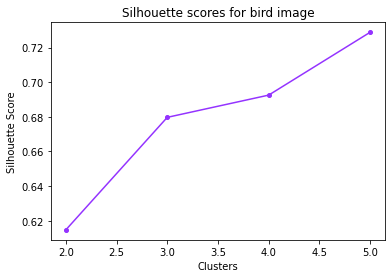

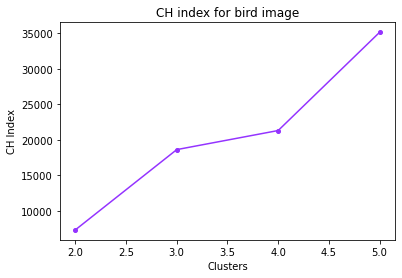

k = 5 gives good clustering


In [41]:
plt.plot([2, 3, 4, 5], silhouetteScore, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('Silhouette scores for bird image')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.show()
plt.close()

plt.plot([2, 3, 4, 5], chIndex, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('CH index for bird image')
plt.xlabel('Clusters')
plt.ylabel('CH Index')
plt.show()
plt.close()

print('k = 5 gives good clustering')

In [58]:
birdSample['label'] = bird_km[3].labels_  # adding labels for k = 5 clustering
birdSample.head()

,x,y,r,g,b,label
94059,0.018750,0.610417,0.413934,0.452381,0.392713,3
52923,0.871875,0.341667,0.598361,0.714286,0.724696,2
27628,0.068750,0.179167,0.741803,0.829365,0.789474,0
136771,0.078125,0.887500,0.733607,0.821429,0.781377,1
108806,0.962500,0.704167,0.745902,0.789683,0.773279,4


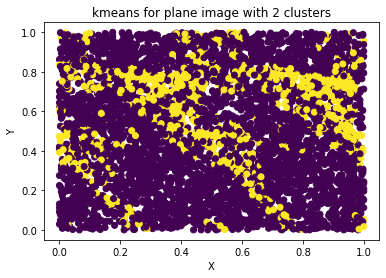

Silhouette score: 0.4569392476061721
CH score: 3157.6777949524244


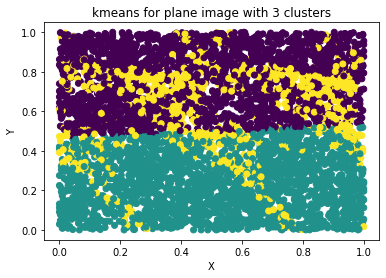

Silhouette score: 0.3547917422485485
CH score: 3344.356214301161


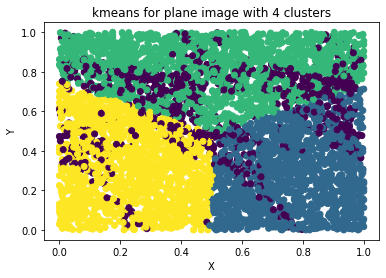

Silhouette score: 0.3699594201285131
CH score: 3556.3689703661194


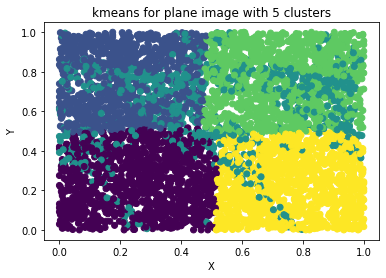

Silhouette score: 0.37697512132707733
CH score: 3660.9075012275384


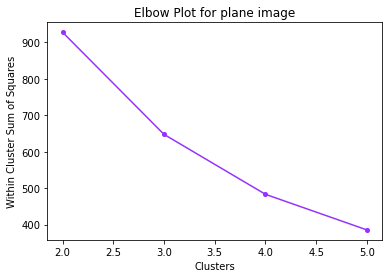

In [45]:
plane_km = []
wcss = []
silhouetteScore = []
chIndex = []

for i in range(2, 6):
    res = kmeans(planeSample, i)
    plane_km.append(res)
    planeSample['label'] = res.labels_
    plt.scatter(planeSample['x'], planeSample['y'], c = planeSample['label'])
    plt.title('kmeans for plane image with {} clusters'.format(i))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    plt.close()
    sh = metrics.silhouette_score(birdSample.values, res.labels_)
    silhouetteScore.append(sh)
    print('Silhouette score:', sh)
    ch = metrics.calinski_harabasz_score(birdSample.values, res.labels_)
    chIndex.append(ch)
    print('CH score:', ch)
    
    
for i in plane_km:
    wcss.append(i.inertia_)

plt.plot([2, 3, 4, 5], wcss, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('Elbow Plot for plane image')
plt.xlabel('Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()
plt.close()

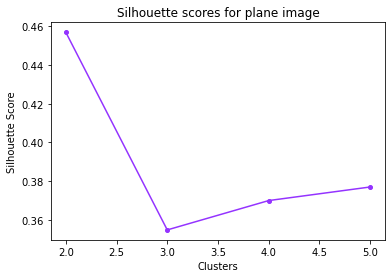

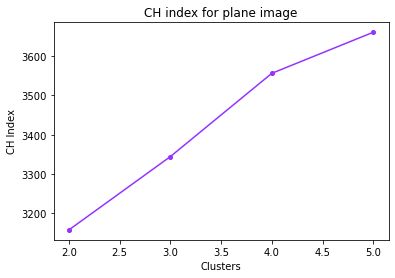

k = 5 gives good clustering


In [47]:
plt.plot([2, 3, 4, 5], silhouetteScore, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('Silhouette scores for plane image')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.show()
plt.close()

plt.plot([2, 3, 4, 5], chIndex, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('CH index for plane image')
plt.xlabel('Clusters')
plt.ylabel('CH Index')
plt.show()
plt.close()

print('k = 5 gives good clustering')

In [57]:
planeSample['label'] = plane_km[3].labels_  # adding labels for k = 5 clustering
planeSample.head()

,x,y,r,g,b,label
94059,0.018750,0.610417,0.086957,0.115385,0.044693,2
52923,0.871875,0.341667,0.782609,0.780220,0.826816,4
27628,0.068750,0.179167,0.755435,0.758242,0.832402,0
136771,0.078125,0.887500,0.532609,0.582418,0.681564,1
108806,0.962500,0.704167,0.538043,0.587912,0.687151,3
